In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
import xgboost as xgb
import optuna

In [2]:
import warnings
warnings.simplefilter("ignore")

# Load dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")
train_df.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


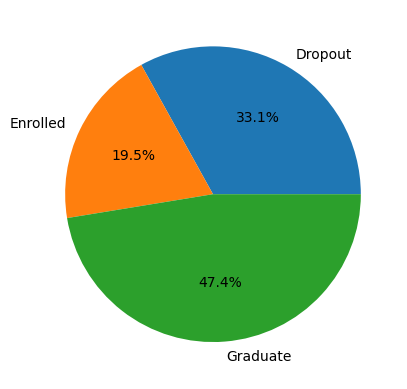

In [4]:
target_labels, target_counts = np.unique(train_df["Target"], return_counts=True)
plt.pie(target_counts, labels=target_labels, autopct="%.1f%%")
plt.show()

In [5]:
labels = list(train_df.columns)
labels.remove("id")
labels.remove("Target")
labels, len(labels)

(['Marital status',
  'Application mode',
  'Application order',
  'Course',
  'Daytime/evening attendance',
  'Previous qualification',
  'Previous qualification (grade)',
  'Nacionality',
  "Mother's qualification",
  "Father's qualification",
  "Mother's occupation",
  "Father's occupation",
  'Admission grade',
  'Displaced',
  'Educational special needs',
  'Debtor',
  'Tuition fees up to date',
  'Gender',
  'Scholarship holder',
  'Age at enrollment',
  'International',
  'Curricular units 1st sem (credited)',
  'Curricular units 1st sem (enrolled)',
  'Curricular units 1st sem (evaluations)',
  'Curricular units 1st sem (approved)',
  'Curricular units 1st sem (grade)',
  'Curricular units 1st sem (without evaluations)',
  'Curricular units 2nd sem (credited)',
  'Curricular units 2nd sem (enrolled)',
  'Curricular units 2nd sem (evaluations)',
  'Curricular units 2nd sem (approved)',
  'Curricular units 2nd sem (grade)',
  'Curricular units 2nd sem (without evaluations)',
  'U

In [6]:
mm = MinMaxScaler()
X = mm.fit_transform(train_df[labels])
Y = train_df["Target"].apply(lambda x: list(target_labels).index(x))

train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size=0.2, random_state=42)

test_x = test_df[labels]
test_x = mm.transform(test_x)


print(
f"""
Train Size : {len(train_x)}
Valid Size : {len(valid_x)}
Test  Size : {len(test_x)}
"""
)


Train Size : 61214
Valid Size : 15304
Test  Size : 51012



# Cross validation & Parameter tuning

## LightGBM

In [7]:
tuning = False
N_SPLITS = 5

def lgb_objective(trial: optuna.Trial) -> float:
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "num_iterations": trial.suggest_int("num_iterations", 30, 1000),
#         "max_depth": trial.suggest_int("max_depth", 1, 31),
        "lambda_l1": trial.suggest_float("lambda_l1", 10e-5, 10e3, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 10e-5, 10e3, log=True),
        "seed": 42,
        "verbose": -1
    }

    cv = np.zeros_like(Y)
    kf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    for i, (train_idx, valid_idx) in enumerate(kf.split(X, Y)):
        train_x, train_y = X[train_idx, :], Y[train_idx]
        valid_x, valid_y = X[valid_idx, :], Y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(train_x, train_y)

        cv[valid_idx] = model.predict(valid_x)

    return accuracy_score(y_true=Y, y_pred=cv)


if tuning:
    study = optuna.create_study(study_name="lightgbm", direction="maximize")
    study.optimize(lgb_objective, n_trials=100)
    best_params = study.best_params

else:
    best_params = {
        'learning_rate': 0.04810478621976008, 
        'num_leaves': 20, 
        'num_iterations': 554, 
        'lambda_l1': 5.371074280737708, 
        'lambda_l2': 0.0224004821379888
    }

    
const_params = {
    "seed": 42,
    "verbose": -1
}

params = dict(**const_params, **best_params)

models = []
cv_pred = np.zeros_like(Y)
kf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
for i, (train_idx, valid_idx) in enumerate(kf.split(X, Y)):
    train_x, train_y = X[train_idx, :], Y[train_idx]
    valid_x, valid_y = X[valid_idx, :], Y[valid_idx]

    model = lgb.LGBMClassifier(**params)
    model.fit(train_x, train_y)

    cv_pred[valid_idx] = model.predict(valid_x)
    models.append(model)

print(accuracy_score(Y, cv_pred))

0.8327713740557777


In [14]:
lgb_results = []
for model in models:
    r = model.predict_proba(test_x)
    lgb_results.append(r)

lgb_pred = np.mean(lgb_results, axis=0)
lgb_pred = np.argmax(lgb_pred, axis=1)
lgb_pred = [target_labels[i] for i in lgb_pred]
test_id = test_df["id"]
submission = pd.DataFrame({
    "id": test_id,
    "Target": lgb_pred
})
submission.to_csv("submission_lgb.csv", index=False)

## XGBoost

In [10]:
tuning = True
N_SPLITS = 5

def xgb_objective(trial: optuna.Trial) -> float:
    params = {
        'verbosity': 0,
        "seed": 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    cv = np.zeros_like(Y)
    kf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    for i, (train_idx, valid_idx) in enumerate(kf.split(X, Y)):
        train_x, train_y = X[train_idx, :], Y[train_idx]
        valid_x, valid_y = X[valid_idx, :], Y[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(train_x, train_y)

        cv[valid_idx] = model.predict(valid_x)

    return accuracy_score(y_true=Y, y_pred=cv)


if tuning:
    study = optuna.create_study(study_name="xgboost", direction="maximize")
    study.optimize(xgb_objective, n_trials=100)
    best_params = study.best_params

else:
    best_params = {
        'learning_rate': 0.04810478621976008, 
        'num_leaves': 20, 
        'num_iterations': 554, 
        'lambda_l1': 5.371074280737708, 
        'lambda_l2': 0.0224004821379888
    }


print(best_params)
const_params = {
    'verbosity': 0,
    "seed": 42
}

params = dict(**const_params, **best_params)

models = []
cv_pred = np.zeros_like(Y)
kf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
for i, (train_idx, valid_idx) in enumerate(kf.split(X, Y)):
    train_x, train_y = X[train_idx, :], Y[train_idx]
    valid_x, valid_y = X[valid_idx, :], Y[valid_idx]

    model = xgb.XGBClassifier(**params)
    model.fit(train_x, train_y)

    cv_pred[valid_idx] = model.predict(valid_x)
    models.append(model)

print(accuracy_score(Y, cv_pred))

[I 2024-06-13 06:05:31,405] A new study created in memory with name: xgboost
[I 2024-06-13 06:06:08,868] Trial 0 finished with value: 0.829151310802687 and parameters: {'learning_rate': 0.10689688450854609, 'n_estimators': 109, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.6775350751632419, 'colsample_bytree': 0.8678817300765842}. Best is trial 0 with value: 0.829151310802687.
[I 2024-06-13 06:08:13,358] Trial 1 finished with value: 0.8327713740557777 and parameters: {'learning_rate': 0.07105100490520741, 'n_estimators': 324, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8048361077659734, 'colsample_bytree': 0.5127271858885291}. Best is trial 1 with value: 0.8327713740557777.


0.8331111633863928
{'learning_rate': 0.07105100490520741, 'n_estimators': 324, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8048361077659734, 'colsample_bytree': 0.5127271858885291}


In [12]:
xgb_results = []
for model in models:
    r = model.predict_proba(test_x)
    xgb_results.append(r)

xgb_pred = np.mean(xgb_results, axis=0)
xgb_pred = np.argmax(xgb_pred, axis=1)
xgb_pred = [target_labels[i] for i in xgb_pred]
test_id = test_df["id"]
submission = pd.DataFrame({
    "id": test_id,
    "Target": xgb_pred
})
submission.to_csv("submission_xgb.csv", index=False)

# Predict & Submission

In [23]:
pred = xgb_results + lgb_results
pred = np.mean(pred, axis=0)
pred = [target_labels[i] for i in pred.argmax(axis=1)]
submission = pd.DataFrame({
    "id": test_id,
    "Target": pred
})
submission.to_csv("submission.csv", index=False)

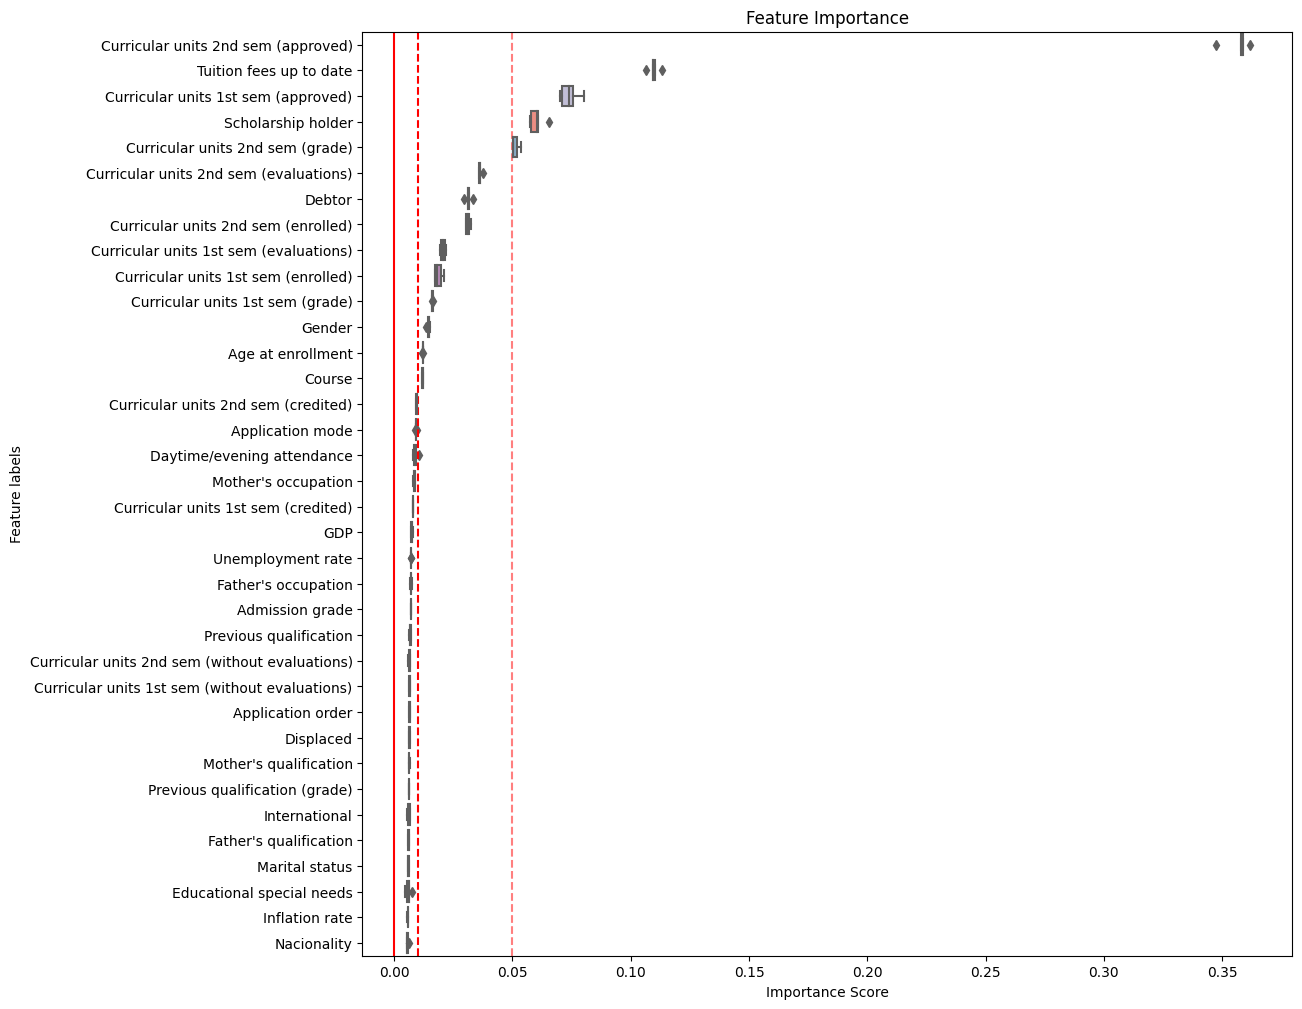

In [63]:
F = []
for model in models:
    fi = model.feature_importances_
    F.append(fi)

idx = np.array(F).mean(axis=0).argsort()
df_fi = pd.DataFrame(np.array(F)[:, idx[::-1]], columns=np.array(labels)[idx[::-1]])

fig = plt.figure(figsize=(12, 12))
sns.boxplot(df_fi, orient="h", palette="Set3")
plt.axvline(0, color="red")
plt.axvline(0.01, linestyle="--", color="red")
plt.axvline(0.05, linestyle="--", color="red", alpha=0.5)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature labels")
plt.show()